# Central Software challenge MNIST dataset - Data Scientist aplication
*Developed by Albert Sanz*

In the following notbook the problem for Scentral software challenge appling MNIST dataset is solved.
There are two ways to execute the code: You can apply a single model or use grid_search model to find which combination has the best model by searching best f1_score. You can adjust the parameter 'grid_search' at the main code part.
The code is distributed in the following way:
1. Required Imports
2. Feature Engeneering functions
3. Modeling functions
4. Data Visualization functions
5. Main code
6. Others

Each part may include a brief explanation.


### 0. Label Distribution
New labels: [old labels]  - numeric conversion meaning:

        {'Upper part': ['T-shirt/top', 'Pullover', 'Coat', 'Shirt']
        'Bottom part': ['Trouser']
        'One piece': ['Dress']
        'Footwear': ['Sandal', 'Sneaker', 'Ankle boot']
        'Bags': ['Bag']}

### 1. Required Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

### 2. Data Engeneering functions

The function below is applied to balance data and it used only over the training dataset to balance the labels
It's considered that the new label containing the most number of old labels need all samples to avoid getting underfitting.
Therefore, upsampling is applied over the other labels

The upsampling is applied statically due to time limitation, but on the real world this must be applied dynamically

In [2]:
def data_balancer(images, labels):
    """
    Balance train dataset. Label 0 is 400% times bigger than labels 1, 2 and 4. And it's 25% times bigger than label 3.
    For labels 1, 2 and 4 the set is augmented 3 times more and being added with itself ( original).
    As for label 3, 1800 random samples per each old_label conforming it are taken to generate more samples
    :param images: Original train dataset with images features. np.array
    :param labels: Original train dataset with label features. pd.dataframe
    :return:
    np.array with the balanced image dataset
    pd.Dataframe with the balanced labels dataset
    """
    balanced_images = []
    balanced_labels = []
    for i, group in labels.groupby('new_labels'):
        pivot_img = np.take(images, group.index, axis=0)
        if i not in [0, 3]:
            transform_img = np.vstack([pivot_img] * 3)
            transform_img = transform_data(transform_img)
            temp_labels = pd.concat([group] * 4)
            balanced_images.append(np.concatenate([pivot_img, transform_img]))
            balanced_labels.append(temp_labels)
        elif i == 3:
            for _, old_group in group.groupby('old_labels'):
                img_group = np.take(images, old_group.index, axis=0)
                temp_labels = old_group.sample(n=1800)
                sub_pivot_img = np.take(images, temp_labels.index, axis=0)
                generated_img = transform_data(sub_pivot_img)
                balanced_images.append(np.concatenate([img_group, generated_img]))
                balanced_labels.append(pd.concat([old_group, temp_labels]))
        else:
            balanced_images.append(pivot_img)
            balanced_labels.append(group)
    return np.concatenate(balanced_images), pd.concat(balanced_labels).reset_index(drop=True)

In [3]:
def transform_labels(label):
  """Generates new labels based on the new required label distribution"""
  if label in [0, 2, 4, 6]:
    return 0  # Upper Part
  elif label == 1:
    return 1  # Bottom Part
  elif label == 3:
    return 2  # One Piece
  elif label in [5, 7, 9]:
    return 3  # Footwear
  return 4  # Bags

In [4]:
def transform_data(images):
  """It returns the modified passed image.
      Modifies: Contrast, Brightness, horizontal flip and Rotation randomly"""
  datagen = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.8),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1)
  ])
  return datagen(images)

### 2. Modeling and gridsearch functions

In [5]:
def generate_combinations(variants_dict):
    """
    {a: [x, y]
     b: [w, z]}
    :param variants_dict: dict with list of variables
    :return:
    [{a:x, b:w}, {a:y, b:w}, {a:x, b:z}, {a:y, b:z}]
    """
    temp_dict = sorted(variants_dict)
    combinations = [dict(zip(temp_dict, prod)) for prod in itertools.product(*(variants_dict[spec] for spec in temp_dict))]
    return combinations

In [6]:
def grid_search_combinations():
  """
  Edit the gridsearch through this function. You can add / remove parameters and combinations.
  Warning: If you are too greedy with the amount of combinations the execution might take long and out of memory error may occur.
  :return:
  """
  combinations = {
    'conv_layers': [[32, 16], [64, 32], [128, 64, 32]],
    'conv_batch_norm': [True, False],
    'conv_dropout': [0.0, 0.2, 0.5],
    'dense_layers': [[128, 64, 32], [64, 32, 16], [128, 32, 16], [128, 32, 64, 16]],
    'dense_batch_norm': [True, False],
    'dense_dropout': [0.0, 0.2, 0.5]
  }
  return combinations

In [7]:
def gridsearch_model_generator(input_shape, conv_layers=None, conv_batch_norm=True, conv_dropout=0.2, dense_layers=None,
                               dense_batch_norm=True, dense_dropout=0.2):
  """
  Generates and train the model over the grisearch loop.
  input_shape: Features shape (lenght, wirth, channels)
  conv_layers: List of filters per each conv layer wanted. Number of conv layers = len(conv_layers)
  conv_batch_norm: If BatchNormalization is applied at the convolutional part
  conv_dropout: Rate for the conv dropout part. If 0.0 it doesn't apply.
  dense_layers: List of nodes per each dense layer. Number of dense layers = len(dense_layers)
  dense_batch_norm: If BratchNormalization is applied on Dense part
  dense_dropout: Rate for the dropout in the dense part. If 0.0 it doesn't apply.
  returns:
  keras model and prints the model summary.
  """
  if dense_layers is None:
      dense_layers = [128, 64]
  if conv_layers is None:
      conv_layers = [32, 16]
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Rescaling(1. / 255, input_shape=input_shape))
  for layer in conv_layers:
    model.add(tf.keras.layers.Conv2D(layer, kernel_size=(3, 3), activation='relu'))
    if conv_batch_norm:
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    if conv_dropout > 0.0:
      model.add(tf.keras.layers.Dropout(conv_dropout))
  model.add(tf.keras.layers.Flatten())
  for layer in dense_layers:
    model.add(tf.keras.layers.Dense(layer, activation='relu'))
    if dense_batch_norm:
      model.add(tf.keras.layers.BatchNormalization())
    if dense_dropout > 0.0:
      model.add(tf.keras.layers.Dropout(dense_dropout))
  # Output layer with the number of new_label classes (5 in your case)
  model.add(tf.keras.layers.Dense(5, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

In [8]:
def model_generator(input_shape):
  """
  Generates a single model. This is faster than gridsearch but might not get best solution.
  The model has the following parts:
  As input layer there's a rescaling function to convert images with values form 0-255 to 0-1
  Next, there are two conolutional layers with 32 and 64 filters applying BatchNormalization, MaxPooling
  and Dropout with a rate of 0.2
  Between Convolutional and Dense there's a Flatten layer
  After flatten the data there're two fully-connected layers with 256 and 128 nodes.
  BatchNormalization and dropout with a rate of 0.5 is applied at the Dense part.
  Output layer has a fully-connected layer with 5 nodes (One per possible outcome)
  and as the problem is non-binary classification 'softmax' is applied.
  input_shape: Features shape (lenght, wirth, channels)
  returns tf.keras model and prints the summary
  """
  model = tf.keras.Sequential()
  # Normalize image 0-255 to 0-1
  # model.add(tf.keras.layers.Normalization(input_shape=input_shape))
  model.add(tf.keras.layers.Rescaling(1./255, input_shape=input_shape))
  # Convolutional layers
  model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Flatten())
  # Dense layers
  model.add(tf.keras.layers.Dense(256, activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  # Output layer with the number of new_label classes (5 in your case)
  model.add(tf.keras.layers.Dense(5, activation='softmax'))
  # One hot label first
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

In [9]:
def train_model(model, x_train, y_train, x_val, y_val, epochs):
  """
  Trains a keras model.
  Callback applied: Learning rate annealing -> Reduces or increases the LR according the previous epoch loss performance.
  Modifies the LR per each epoch.
  """
  annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
  history = model.fit(x=x_train, y=y_train, batch_size=64, validation_data=(x_val, y_val), epochs=epochs,
                      callbacks=[annealer])
  return history

### 3. Data Visualization functions

In [10]:
def plot_history(history):
  """ Plots a specific training and validation model history"""
  plt.style.use('ggplot')
  plt.style.use('ggplot')
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [11]:
def plot_confusion_matrix(y_pred, y_true):
  """Do not pass the labels in one-hot format"""
  class_names = ['Upper Part', 'Bottom Part', 'One Piece', 'Footwear', 'Bags']
  cmd = ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_true, display_labels=class_names, normalize='true')
  cmd.plot(values_format=".2f", xticks_rotation=45)
  # Set axis labels
  plt.title("Confusion Matrix for Test Dataset")
  plt.grid(visible=None)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.tight_layout()
  plt.show()

In [18]:
def plot_image_per_label(images, labels):
  class_names = [
      'T-shirt/top', 'Trouser', 'Pullover', 'Dress',
      'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]
  # Create a dictionary to store one image per label
  one_image_per_label = {}
  # Iterate through the dataset to find one sample for each unique label
  for i in range(len(labels)):
    label = labels[i]
    if label not in one_image_per_label:
      one_image_per_label[label] = images[i]

  # Plot one image per label
  plt.figure(figsize=(12, 8))
  for label, image in one_image_per_label.items():
    plt.subplot(2, 5, label + 1)  # Assumes there are 10 unique labels
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {class_names[label]}')
    plt.axis('off')

  plt.tight_layout()
  plt.show()

In [13]:
def plot_image_transformation(image):
  # Plot the original and modified images side by side
  modified_image = transform_data(image)
  plt.figure(figsize=(8, 4))
  plt.subplot(1, 2, 1)
  plt.imshow(image, cmap='gray')
  plt.title('Original Image')
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(np.squeeze(modified_image), cmap='gray')  # Remove the single channel dimension
  plt.title('Modified Image')
  plt.axis('off')
  plt.show()

In [14]:
def plot_data_distribution(labels_dataset, ds_type='Train', new_labels=False):
  if new_labels:
    class_names = [
    'Upper part', 'Bottom part', 'One piece', 'Footwear', 'Bags'
    ]
  else:
    class_names = [
      'T-shirt/top', 'Trouser', 'Pullover', 'Dress',
      'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]

  # Plot the label distribution
  plt.figure(figsize=(8, 6))
  if new_labels:
    plt.figure(figsize=(8, 6))
    plt.hist(labels_dataset, bins=np.arange(6) - 0.5, rwidth=0.9, alpha=0.7, color='b')
    plt.xticks(np.arange(5), class_names, rotation=45)
  else:
    plt.hist(labels_dataset, bins=np.arange(11) - 0.5, rwidth=0.9, alpha=0.7, color='b')
    plt.xticks(np.arange(10), class_names, rotation=45)
  plt.xlabel("Labels")
  plt.ylabel("Count")
  plt.title(f"Fashion MNIST Label Distribution for {ds_type}")
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()
  plt.show()

### 4. Main Code
The main code will be posted in diferent parts, It's important to execute them in right order (descending)

In [15]:
# Global variables
best_score = 0.0
best_history = None
best_model = None
# You can midify the following variable if you want to apply
grid_search = False

Load data and data preprocessing

In [16]:
# Load raw data
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# Get from original train -> Train + val datasets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.10, random_state=42, stratify=train_labels)
# Expand the image dimensionallity to add the channel information (1 as it's grayscale)
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)
# Transforms labels to dataframe for an easy management
train_labels = pd.DataFrame({'old_labels': train_labels})
val_labels = pd.DataFrame({'old_labels': val_labels})
test_labels = pd.DataFrame({'old_labels': test_labels})
# Apply new labels in a new column at the labels dataset
train_labels['new_labels'] = train_labels['old_labels'].apply(lambda x: transform_labels(x))
val_labels['new_labels'] = val_labels['old_labels'].apply(lambda x: transform_labels(x))
test_labels['new_labels'] = test_labels['old_labels'].apply(lambda x: transform_labels(x))

4422102/4422102 [==============================] - 0s 0us/step


Plot images per label and to check how data augmentation function works

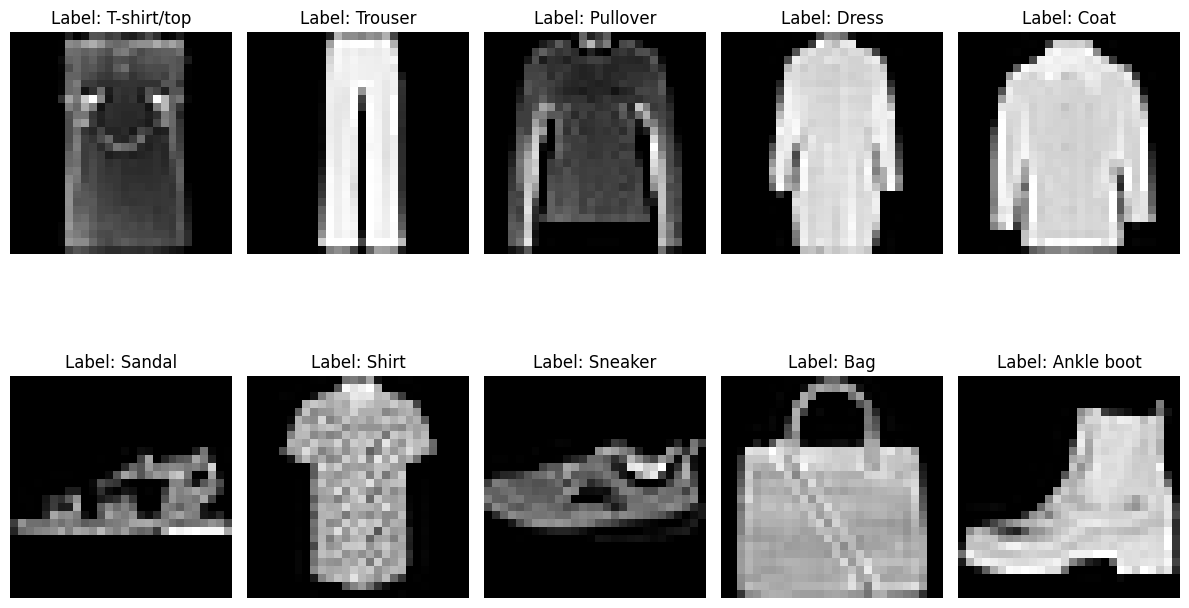

In [19]:
# Plot one image per label
plot_image_per_label(train_images, train_labels['old_labels'].values)

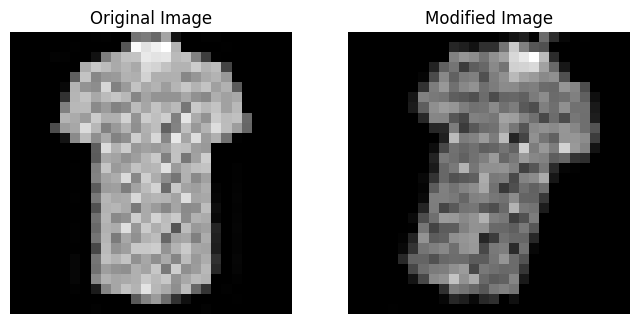

In [20]:
# Plot data augmentation sample
plot_image_transformation(train_images[7])

Plot data distributions

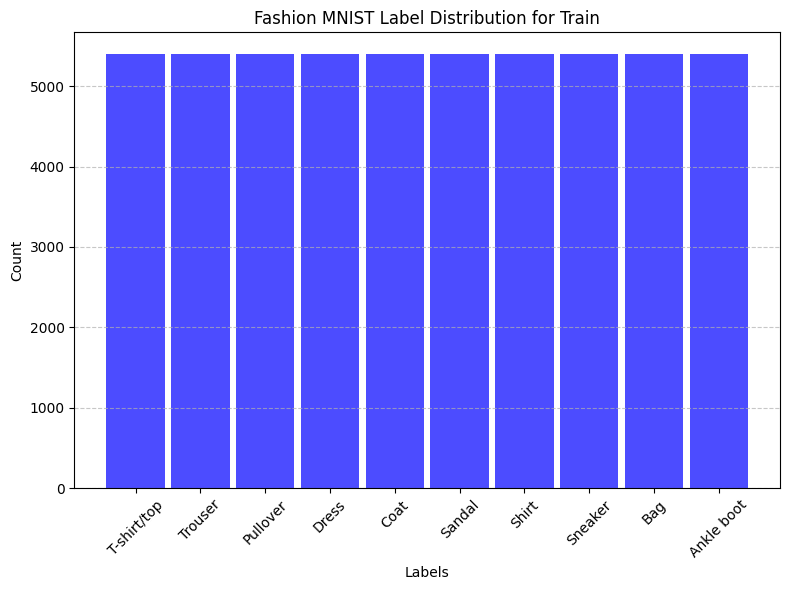

In [21]:
# Plot the original label distributions (It can be apreciated labels are balanced distributed)
# Train dataset
plot_data_distribution(train_labels['old_labels'].values)

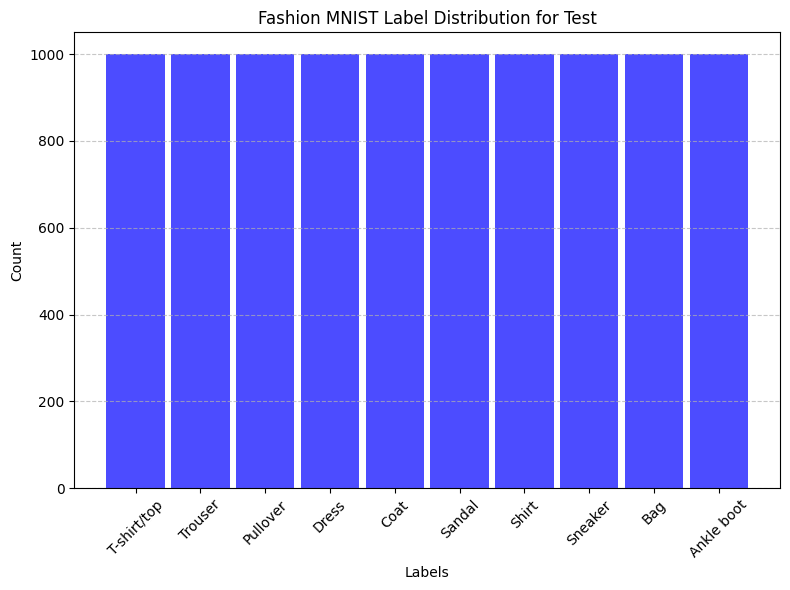

In [22]:
# Test dataset
plot_data_distribution(test_labels['old_labels'].values, ds_type='Test')

<Figure size 800x600 with 0 Axes>

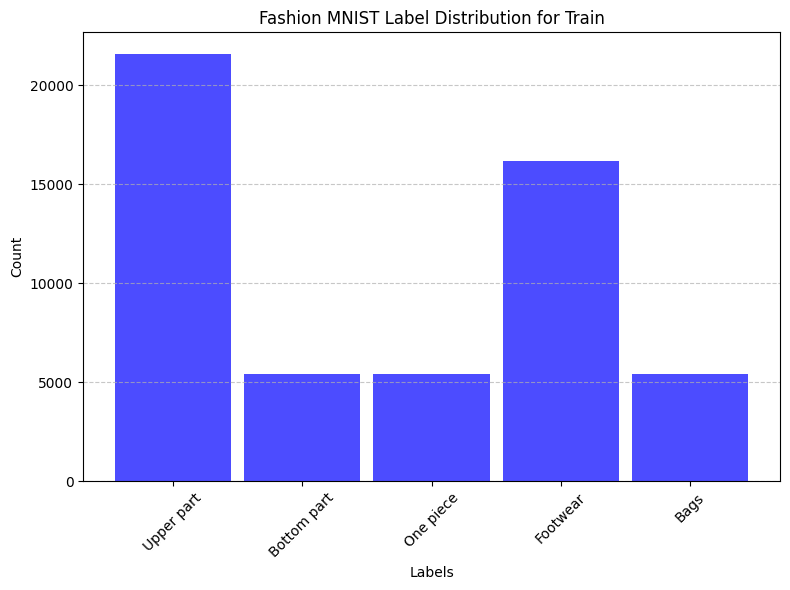

In [23]:
# Now we plot the label distribution for new label. It's unbalanced
# Train
plot_data_distribution(train_labels['new_labels'].values, new_labels=True)

<Figure size 800x600 with 0 Axes>

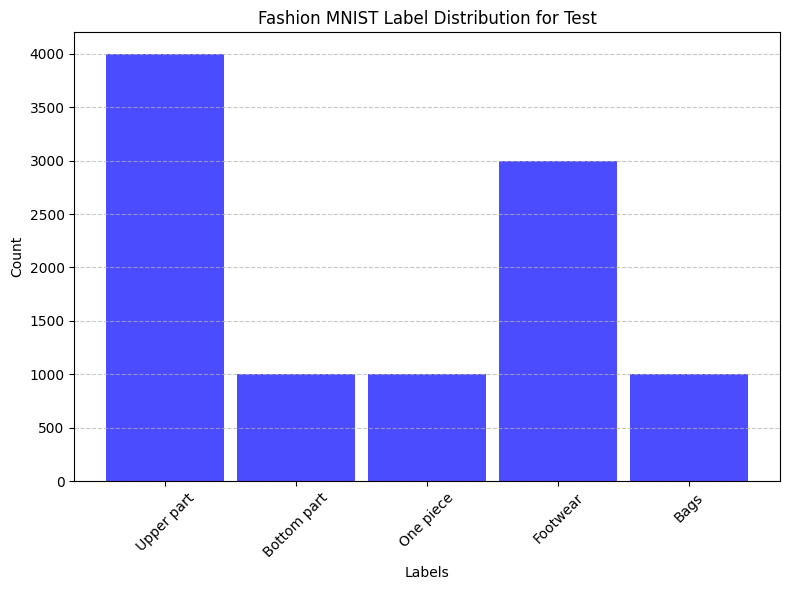

In [24]:
# Now we plot the label distribution for new label. It's unbalanced
# Test
plot_data_distribution(test_labels['new_labels'].values, ds_type='Test', new_labels=True)

Balancing labels with data augmentation to upsampling new labels 1, 2, 3 and 4. With syntethic images.

In [25]:
# We have to ONLY balance the train dataset to get better model performance
train_images, train_labels = data_balancer(train_images, train_labels)

<Figure size 800x600 with 0 Axes>

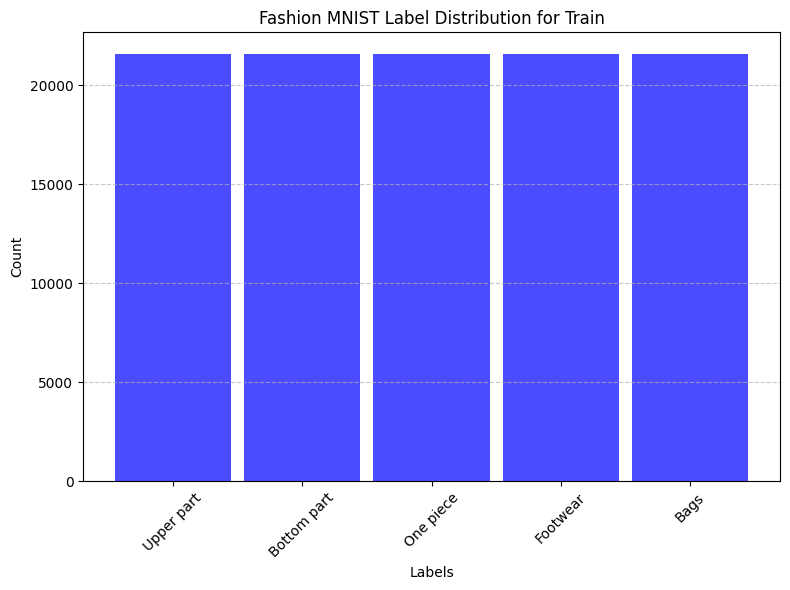

In [26]:
# We can see now the train datasets are balanced
plot_data_distribution(train_labels['new_labels'].values, new_labels=True)

Generate one-hot format labels

In [27]:
# Transform the labels to one-hot ( required to perform train)
train_labels = tf.keras.utils.to_categorical(train_labels['new_labels'].values, num_classes=5)
# Val and Test are not required to be transformed. Optional
val_labels = tf.keras.utils.to_categorical(val_labels['new_labels'].values, num_classes=5)
test_labels = tf.keras.utils.to_categorical(test_labels['new_labels'].values, num_classes=5)

Model generation, compilation and train loop

In [28]:
if grid_search:
  combinations = generate_combinations(grid_search_combinations())
  model = None
  for combination in combinations:
    model = gridsearch_model_generator(train_images.shape[1:], **combination)
    hist = train_model(model, train_images, train_labels, val_images, val_labels, 5)
    # Validate best model by computing f1-score
    val_pred = model.predict(val_images, verbose=0)
    val_score = f1_score(y_pred=np.argmax(val_pred, axis=1), y_true=np.argmax(val_labels, axis=1),
                         average='weighted')
    if val_score > best_score:
      best_score = val_score
      best_model = model
      best_history = hist

else: # Not grid search
  model = model_generator(train_images.shape[1:])
  hist = train_model(model, train_images, train_labels, val_images, val_labels, 5)
  # Validate best model by computing f1-score
  val_pred = model.predict(val_images, verbose=0)
  val_score = f1_score(y_pred=np.argmax(val_pred, axis=1), y_true=np.argmax(val_labels, axis=1), average='weighted')
  if val_score > best_score:
    best_score = val_score
    best_model = model
    best_history = hist

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 26, 26, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)       

From best model or unique model, we print its training performance

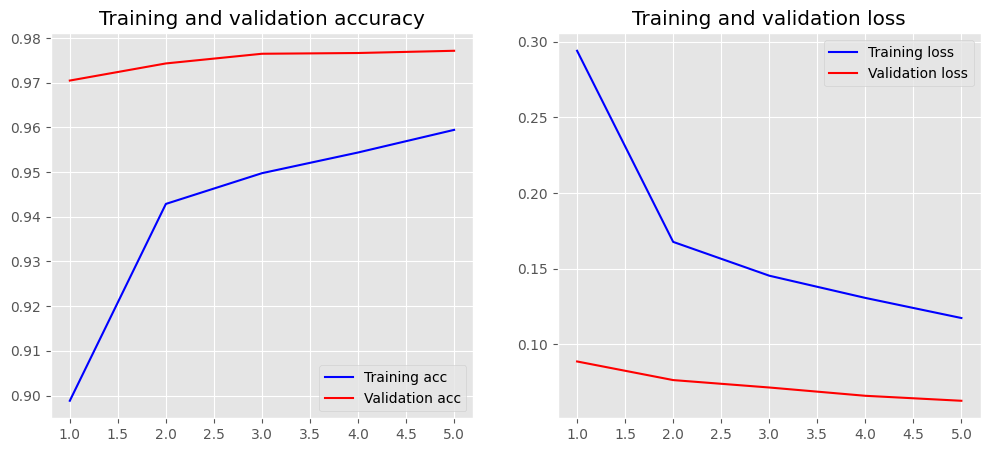

In [29]:
# Plot hist from best f1-score
plot_history(best_history)

Last, test set is applied over the trained and validated model to check the 'real' performance.

Conf Matrix is plotted and the f1-score metric is printed

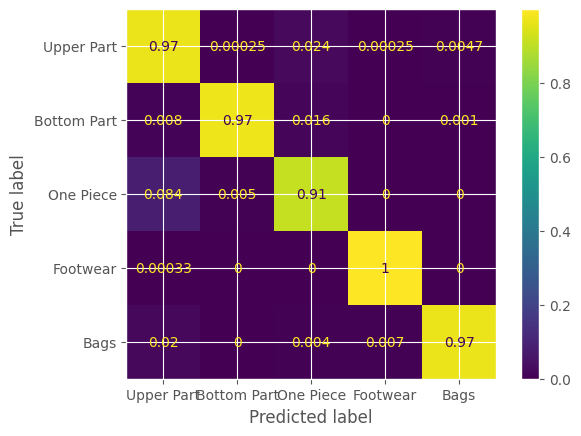

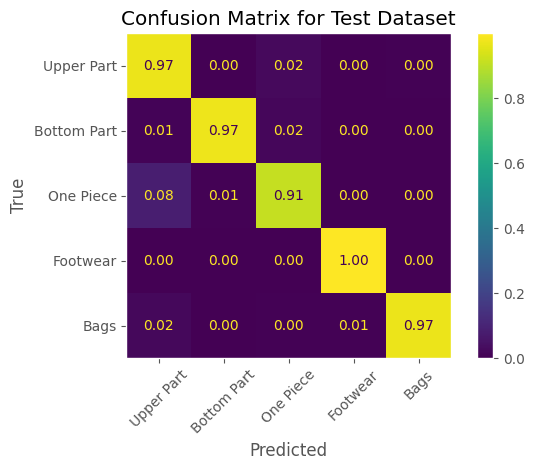

F1-score in Test: 0.9738023345389202


In [30]:
# Plot confusing matrix from best model test and get f1-score, test results.
model = best_model
test_pred = model.predict(test_images, verbose=0)
plot_confusion_matrix(y_pred=np.argmax(test_pred, axis=1), y_true=np.argmax(test_labels, axis=1))
f1_test = f1_score(y_pred=np.argmax(test_pred, axis=1), y_true=np.argmax(test_labels, axis=1), average='weighted')
print(f'F1-score in Test: {f1_test}')

### 6. Others
Other code to be applied over the code:

- Store a trained model
- Predict from an image. For fun!

In [ ]:
def predict_image(model, image_file):
    """
    Predicts the label form custom image. Given a trained model
    :param model: You can either pass a trained model (tf.keras) or model filepath and it wil loaded.
    :param image_file: Image filepath
    :return:
    prints the model prediction from one of the class ['Upper Part', 'Bottom Part', 'One Piece', 'Footwear', 'Bags'].
    """
    class_names = ['Upper Part', 'Bottom Part', 'One Piece', 'Footwear', 'Bags']
    image = cv2.imread(image_file)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(gray_image, (28, 28))
    if isinstance(model, str):
        model = tf.keras.models.load_model(model)
    image = np.expand_dims(image, axis=-1)  # add channel
    image = np.expand_dims(image, axis=0)  # add batch
    pred = model.predict(image, verbose=0)
    print(f'Model thinks this image is from class: {class_names[np.argmax(pred, axis=1)[0]]}')

In [ ]:
# Uncomment this line and modify the filepath to store a trained keras model (.h5)
# model.save('model.h5')
predict_image(model, 'plot/test_img2.png')